# Imports

Please use the provided `hds_stoch` environment for this work.  

In [1]:
import numpy as np
import pandas as pd
import itertools
import math
import matplotlib.pyplot as plt
import simpy
from joblib import Parallel, delayed
import warnings
from scipy.stats import t
#from treat_sim.distributions import Exponential, Lognormal

# Distribution classes

To help you build your model, the notebook includes some pre-written distribution classes that you may wish to use to setup sampling.  You are free to use these, but you can choose not too if you have an approach you prefer. 

In [2]:
class Exponential:
    '''
    Convenience class for the exponential distribution.
    packages up distribution parameters, seed and random generator.
    '''
    def __init__(self, mean, random_seed=None):
        '''
        Constructor
        
        Params:
        ------
        mean: float
            The mean of the exponential distribution
        
        random_seed: int, optional (default=None)
            A random seed to reproduce samples.  If set to none then a unique
            sample is created.
        '''
        self.rand = np.random.default_rng(seed=random_seed)
        self.mean = mean
        
    def sample(self, size=None):
        '''
        Generate a sample from the exponential distribution
        
        Params:
        -------
        size: int, optional (default=None)
            the number of samples to return.  If size=None then a single
            sample is returned.
        '''
        return self.rand.exponential(self.mean, size=size)

class Lognormal:
    """
    Encapsulates a lognormal distirbution
    """
    def __init__(self, mean, stdev, random_seed=None):
        """
        Params:
        -------
        mean = mean of the lognormal distribution
        stdev = standard dev of the lognormal distribution
        """
        self.rand = np.random.default_rng(seed=random_seed)
        mu, sigma = self.normal_moments_from_lognormal(mean, stdev**2)
        self.mu = mu
        self.sigma = sigma
        
    def normal_moments_from_lognormal(self, m, v):
        '''
        Returns mu and sigma of normal distribution
        underlying a lognormal with mean m and variance v
        source: https://blogs.sas.com/content/iml/2014/06/04/simulate-lognormal
        -data-with-specified-mean-and-variance.html

        Params:
        -------
        m = mean of lognormal distribution
        v = variance of lognormal distribution
                
        Returns:
        -------
        (float, float)
        '''
        phi = math.sqrt(v + m**2)
        mu = math.log(m**2/phi)
        sigma = math.sqrt(math.log(phi**2/m**2))
        return mu, sigma
        
    def sample(self):
        """
        Sample from the normal distribution
        """
        return self.rand.lognormal(self.mu, self.sigma)

# Utility functions

In [3]:
def trace(msg):
    '''
    Utility function for printing simulation
    set the TRACE constant to FALSE to 
    turn tracing off.
    
    Params:
    -------
    msg: str
        string to print to screen.
    '''
    if TRACE:
        print(msg)

# Model parameters

The constants below provides hard coded data representing the base case or 'as-is' state of the minor injury unit.   

In [4]:
# These are the parameters for a base case model run.

# run length in days
RUN_LENGTH = 365

DEFAULT_WARMUP_AUDIT_INTERVAL = 1

# default № of reps for multiple reps run
DEFAULT_N_REPS = 5

# default random number SET
DEFAULT_RNG_SET = None
N_STREAMS = 10

# Turn off tracing
TRACE = False

# resource counts
N_BEDS = 9

# time between arrivals in minutes (exponential)
# for acute stroke, TIA and neuro respectively
MEAN_IATs = [1.2, 9.5, 3.5]

# treatment (lognormal)
# for acute stroke, TIA and neuro respectively
TREAT_MEANs = [7.4, 1.8, 2.0]
TREAT_STDs = [8.5, 2.3, 2.5]

# Scenario class
In the cell below the parameters you will find a `Scenario` class.  This makes use of the default parameters to set up the base case scenario.  Remember that its good practice to pass all of your parameters to your simulation model in a **container**.  A class is a flexible way to achieve this aim.

In [5]:
class Scenario:
    '''
    Parameter container class for minor injury unit model.
    '''
    def __init__(self, random_number_set=DEFAULT_RNG_SET):
        '''
        The init method sets up our defaults. 
        
        Params:
        -------
        
        name - str or None
            optional name for scenario
        '''
        
        # warm-up
        self.warm_up = 0.0
        
        # either hard-coded or obtained from streamlit
        self.iat_means = MEAN_IATs
        self.treat_means = TREAT_MEANs
        self.treat_stds = TREAT_STDs

        # sampling
        self.random_number_set = random_number_set
        self.init_sampling()
        
        # number of beds
        self.n_beds = N_BEDS
        
        
    def set_random_no_set(self, random_number_set):
        '''
        Controls the random sampling 

        Parameters:
        ----------
        random_number_set: int
            Used to control the set of psuedo random numbers
            used by the distributions in the simulation.
        '''
        self.random_number_set = random_number_set
        self.init_sampling()
        
        
    def init_sampling(self):
        '''
        Create the distributions used by the model and initialise 
        the random seeds of each.
        '''
        # create random number streams
        rng_streams = np.random.default_rng(self.random_number_set)
        self.seeds = rng_streams.integers(0, 999999999, size=N_STREAMS)
        
        
        # inter-arrival distributions samples
        self.arrival_dist_samples = {
            'stroke': Exponential(self.iat_means[0], random_seed=self.seeds[0]),
            'tia': Exponential(self.iat_means[1], random_seed=self.seeds[1]),
            'neuro': Exponential(self.iat_means[2], random_seed=self.seeds[2])
        }
        
        # treatment distributions samples
        self.treatment_dist_samples = {
            'stroke': Lognormal(self.treat_means[0], self.treat_stds[0], random_seed=self.seeds[3]),
            'tia': Lognormal(self.treat_means[1], self.treat_stds[1], random_seed=self.seeds[4]),
            'neuro': Lognormal(self.treat_means[2], self.treat_stds[2], random_seed=self.seeds[5])
        }
            
        

# Model building

In [6]:
class Patient:
    '''
    Patient in the minor ED process
    '''
    def __init__(self, identifier, patient_type, env, args):
        '''
        Constructor method
        
        Params:
        -----
        identifier: int
            a numeric identifier for the patient.
            
        env: simpy.Environment
            the simulation environment
            
        args: Scenario
            The input data for the scenario
        '''
        # patient id and environment
        self.identifier = identifier
        self.env = env
        
        # treatment parameters
        self.patient_type = patient_type
        self.beds = args.beds
        self.treatment_dist_samples = args.treatment_dist_samples
                
        # individual patient metrics
        self.queue_time = 0.0
        self.treat_time = 0.0
        
    def get_treatment_dist_sample(self):

        # sample for patient pathway
        if self.patient_type == 'stroke':
            self.treat_time = self.treatment_dist_samples['stroke'].sample()
        elif self.patient_type == 'tia':
            self.treat_time = self.treatment_dist_samples['tia'].sample()
        else:
            self.treat_time = self.treatment_dist_samples['neuro'].sample()  
                
        activity_duration = self.treat_time
            
        return activity_duration
        
    
    def treatment(self):

        # record the time that patient entered the system
        arrival_time = self.env.now
     
        # get a bed
        with self.beds.request() as req:
            yield req
            

            self.queue_time = self.env.now - arrival_time
            
            trace(f'Patient № {self.identifier} started treatment at {self.env.now:.3f};' 
                 + f' queue time was {self.queue_time:.3f}') 
            
            
            # treatment delay
            yield self.env.timeout(self.get_treatment_dist_sample())
            
            self.patient_discharged()
    
    def patient_discharged(self):
        
        trace(f'Patient № {self.identifier} discharged at {self.env.now:.3f}')

In [7]:
class MonitoredPatient(Patient):
    '''
    Monitor a Patient.  Inherits from Patient
    Implemented using the observer design pattern
    
    A MonitoredPatient notifies its observers that a patient
    process has reached an event 
    1. completing treatment
    '''
    def __init__(self, admissions_count, patient_type, env, args, model):
        '''
        Constructor
        
        Params:
        -------
        patient: Patient
            patient process to monitor
            
        auditor: Auditor
            auditor
        '''
        super().__init__(admissions_count, patient_type, env, args)
        self._observers = [model]
        
    def register_observer(self, observer):
        self._observers.append(observer)
    
    def notify_observers(self, *args, **kwargs):
        for observer in self._observers: 
            observer.process_event(*args, **kwargs)
    
    def patient_discharged(self):
        super().patient_discharged()
        
        # passes the patient (self) and a message
        self.notify_observers(self, 'patient_discharged')


In [8]:
class ASU:  
    '''
    Model of an ASU
    '''
    def __init__(self, args):
        '''
        Contructor
        
        Params:
        -------
        env: simpy.Environment
        
        args: Scenario
            container class for simulation model inputs.
        '''
        self.env = simpy.Environment()
        self.args = args 
        self.init_model_resources()
        self.patients = []
        
        self.admissions_count = 0
        
        self.stroke_count = 0
        self.tia_count = 0
        self.neuro_count = 0
        
        #running performance metrics:
        self.bed_wait = 0.0
        self.bed_util = 0.0
        
        self.patient_count = 0
            
        self.bed_occupation_time = 0.0
        
        
    def init_model_resources(self):
        '''
        Setup the simpy resource objects
        
        Params:
        ------
        args - Scenario
            Simulation Parameter Container
        '''

        self.args.beds = simpy.Resource(self.env, 
                                   capacity=self.args.n_beds)
        
        
    def run(self, results_collection_period = RUN_LENGTH,
            warm_up = 0):
        '''
        Conduct a single run of the model in its current 
        configuration

        run length = results_collection_period + warm_up

        Parameters:
        ----------
        results_collection_period, float, optional
            default = RUN_LENGTH

        warm_up, float, optional (default=0)
            length of initial transient period to truncate
            from results.

        Returns:
        --------
            None

        '''
        # setup the arrival processes
        self.env.process(self.arrivals_generator('stroke'))
        self.env.process(self.arrivals_generator('tia'))
        self.env.process(self.arrivals_generator('neuro'))
                
        # run
        self.env.run(until=results_collection_period+warm_up)
        
        
    def get_arrival_dist_sample(self):
        
        if self.patient_type == 'stroke':
            inter_arrival_time = self.args.arrival_dist_samples['stroke'].sample()
        elif self.patient_type == 'tia':
            inter_arrival_time = self.args.arrival_dist_samples['tia'].sample()
        else:
            inter_arrival_time = self.args.arrival_dist_samples['neuro'].sample()
        
        return inter_arrival_time
            
        
    def arrivals_generator(self, patient_type):
        self.args.init_sampling()
            
        while True:
                
                self.patient_type = patient_type
            
                if self.patient_type == 'stroke':
                    self.stroke_count += 1
                elif self.patient_type == 'tia':
                    self.tia_count += 1
                else:
                    self.neuro_count += 1    

                iat = self.get_arrival_dist_sample()
                yield self.env.timeout(iat)
                
                self.admissions_count += 1

                trace(f'Patient № {self.admissions_count} ({patient_type}) arrives at {self.env.now:.3f}')
                
                new_patient = MonitoredPatient(self.admissions_count, patient_type, self.env, self.args, self)                

                self.env.process(new_patient.treatment())                 
                
                
                if self.env.now > self.args.warm_up:
                    
                    # keep a record of the patient for results calculation
                    self.patients.append(new_patient)                
    
    
    
    def process_event(self, *args, **kwargs):
        '''
        Running calculates each time a Patient process ends
        (when a patient departs the simulation model)
        
        Params:
        --------
        *args: list
            variable number of arguments. This is useful in case you need to
            pass different information for different events
        
        *kwargs: dict
            keyword arguments.  Same as args, but you can is a dict so you can
            use keyword to identify arguments.
        
        '''
        patient = args[0]
        msg = args[1]
        
        #only run if warm up complete
        if self.env.now < self.args.warm_up:
            return

        if msg == 'patient_discharged':
            self.patient_count += 1
            n = self.patient_count
            
            #running calculation for mean bed waiting time
            self.bed_wait += \
                (patient.queue_time - self.bed_wait) / n

            #running calc for mean bed utilisation
            self.bed_occupation_time += patient.treat_time

                
                
    def run_summary_frame(self):
        
        '''
        Utility function for final metrics calculation.
        
        Returns df containining
        total pts count
        count of each of pts types
        bed utilisation
        mean waiting time of bottom 90% of pts
        % of pts admitted in <4 hours
        '''
        
        
        
        
        
        '''
        # adjust util calculations for warmup period
        rc_period = self.env.now - self.args.warm_up
        util = self.bed_occupation_time / (rc_period * self.args.beds.capacity)
        
        # create nparray of all queue times, convert to hours
        patients_queue_times = np.array([patient.queue_time * 24 for patient in self.patients])
        
        #sort array in descending order, drops top 10% of values, calculate the mean 
        queue_bottom90 = np.mean(np.sort(patients_queue_times)[len(self.patients) // 10:])
        
        # calculate proportion of patient with queue time less than 4 hrs
        percent_4_less = (sum(qt <= 4 for qt in patients_queue_times) / len(self.patients)) * 100
        
        average_treat_time = np.array([patient.treat_time 
                     for patient in self.patients]).sum() / self.patient_count
        

        df = pd.DataFrame({'1':{'1b Stroke Patient Arrivals':self.stroke_count,
                                '2 Bottom 90% Mean Treatment Waiting Time (hrs)': queue_bottom90, 
                                '4 Bed Utilisation (%)': util*100,
                                '1a Total Patient Arrivals':self.patient_count,
                                '1d Neuro Patient Arrivals':self.neuro_count,
                                '1c TIA Patient Arrivals':self.tia_count,
                                '5 Mean Total Time in Unit per patient(hrs)':average_treat_time,
                                '3 Patients Admitted to Unit within 4 hrs of arrival(%)': percent_4_less}})
                                
        '''
        
        
        rc_period = self.env.now - self.args.warm_up
        util = self.bed_occupation_time / (rc_period * self.args.n_beds)
        
        bed_wait = self.bed_wait
        
        
        
        df = pd.DataFrame({'1':{'bed_wait': bed_wait, 
                                'bed_util': util}})        
        
        
        
        df = df.T
        df.index.name = 'rep'
        return df

# Functions for single and multiple runs

In [9]:
def single_run(scenario, 
               rc_period = RUN_LENGTH, 
               warm_up = 0,
               random_no_set = DEFAULT_RNG_SET):
    '''
    Perform a single run of the model and return the results
    
    Parameters:
    -----------
    
    scenario: Scenario object
        The scenario/paramaters to run
        
    rc_period: int
        The length of the simulation run that collects results
        
    warm_up: int, optional (default=0)
        warm-up period in the model.  The model will not collect any results
        before the warm-up period is reached.  
        
    random_no_set: int or None, optional (default=1)
        Controls the set of random seeds used by the stochastic parts of the 
        model.  Set to different ints to get different results.  Set to None
        for a random set of seeds.
        
    Returns:
    --------
        pandas.DataFrame:
        results from single run.
    '''  
        
    # set random number set - this controls sampling for the run.
    if random_no_set is not None:
        scenario.set_random_no_set(random_no_set)
    
    # create the model
    model = ASU(scenario)

    model.run(results_collection_period = rc_period, warm_up = warm_up)
    
    # run the model
    results_summary= model.run_summary_frame()
    
    return results_summary

In [10]:
def multiple_replications(scenario, 
                          rc_period=RUN_LENGTH,
                          warm_up=0,
                          n_reps=DEFAULT_N_REPS, 
                          n_jobs=-1,
                          random_no_set = DEFAULT_RNG_SET):
    '''
    Perform multiple replications of the model.
    
    Params:
    ------
    scenario: Scenario
        Parameters/arguments to configurethe model
    
    rc_period: float, optional (default=DEFAULT_RESULTS_COLLECTION_PERIOD)
        results collection period.  
        the number of minutes to run the model beyond warm up
        to collect results
    
    warm_up: float, optional (default=0)
        initial transient period.  no results are collected in this period

    n_reps: int, optional (default=DEFAULT_N_REPS)
        Number of independent replications to run.

    n_jobs, int, optional (default=-1)
        No. replications to run in parallel.
        
    random_no_set: int or None, optional (default=1)
        Controls the set of random seeds used by the stochastic parts of the 
        model.  Set to different ints to get different results.  Set to None
        for a random set of seeds.
        
    Returns:
    --------
    List
    '''    
    
    
    if random_no_set is not None:
        rng_sets = [random_no_set + rep for rep in range(n_reps)]
    else:
        rng_sets = [None] * n_reps
       
    res = Parallel(n_jobs=n_jobs)(delayed(single_run)(scenario, 
                                                      rc_period, 
                                                      warm_up, 
                                                      random_no_set=rng_set) 
                                    for rng_set in rng_sets)
    
    '''
    res = []
    for rng_set in rng_sets:
        r = single_run(scenario, rc_period, warm_up, random_no_set=rng_set)
        res.append(r)
    '''

    # format and return results in a dataframe
    df_results = pd.concat(res)
    df_results.index = np.arange(1, len(df_results)+1)
    df_results.index.name = 'rep'
    return df_results


# Scripts to run the model

In [11]:
# SINGLE RUN

# base case scenario with default parameters
default_args = Scenario()

print('Running simulation ...', end = ' => ')
results = single_run(default_args, warm_up=250)
print('simulation complete.')

results

Running simulation ... => simulation complete.


,bed_util,bed_wait
rep,,
1,0.720055,0.451805


In [12]:
# MULTIPLE RUN

# default scenario
args = Scenario()

# run multiple replications.
# by default it runs 5 replications.
print('Running multiple replications', end=' => ')
results  = multiple_replications(args, n_reps=10, warm_up=250)
print('done.\n')

# show reps rounded to 2dp
results.round(2)

Running multiple replications => done.



,bed_util,bed_wait
rep,,
1,0.75,1.06
2,0.77,0.57
3,0.72,0.92
4,0.67,0.48
5,0.73,0.56
6,0.76,0.46
7,0.65,0.31
8,0.79,1.16
9,0.71,0.38


In [15]:
results.mean() #9 beds

1a Total Patient Arrivals                                 743.700000
1b Stroke Patient Arrivals                                516.900000
1c TIA Patient Arrivals                                    62.500000
1d Neuro Patient Arrivals                                 176.000000
2 Bottom 90% Mean Treatment Waiting Time (hrs)             30.226225
3 Patients Admitted to Unit within 4 hrs of arrival(%)     64.795070
4 Bed Utilisation (%)                                      74.837372
5 Mean Total Time in Unit per patient(hrs)                  5.776803
dtype: float64

# Warmup period calculation

In [13]:
class WarmupAuditor():
    '''
    Warmup Auditor for the model.
    
    Stores the cumulative means for:
    1. bed waiting time
    2. bed utilisation.
    
    '''
    def __init__(self, model, interval=DEFAULT_WARMUP_AUDIT_INTERVAL):
        self.env = model.env
        self.model = model
        self.interval = interval
        self.bed_wait = []
        self.bed_util = []
        
    def run(self, rc_period):
        '''
        Run the audited model
        
        Parameters:
        ----------
        rc_period: float
            Results collection period.  Typically this should be many times
            longer than the expected results collection period.
            
        Returns:
        -------
        None.
        '''
        # set up data collection for warmup variables.
        self.env.process(self.audit_model())
        self.model.run(rc_period, 0)
        
    def audit_model(self):
        '''
        Audit the model at the specified intervals
        '''
        for i in itertools.count():
            yield self.env.timeout(self.interval)

            
            # Performance metrics
            # calculate the utilisation metrics
            util = self.model.bed_occupation_time / \
                (self.env.now * self.model.args.n_beds)
            
            
            # store the metrics
            self.bed_wait.append(self.model.bed_wait)
            self.bed_util.append(util)

            
    def summary_frame(self):
        '''
        Return the audit observations in a summary dataframe
        
        Returns:
        -------
        pd.DataFrame
        '''
        
        df = pd.DataFrame([self.bed_wait,
                           self.bed_util]).T
        df.columns = ['bed_wait', 'bed_util']
        
        return df

    
def warmup_single_run(scenario, rc_period, 
                      interval=DEFAULT_WARMUP_AUDIT_INTERVAL, 
                      random_no_set=DEFAULT_RNG_SET):
    '''
    Perform a single run of the model as part of the warm-up
    analysis.
    
    Parameters:
    -----------
    
    scenario: Scenario object
        The scenario/paramaters to run
        
    results_collection_period: int
        The length of the simulation run that collects results
               
    audit_interval: int, optional (default=60)
        during between audits as the model runs.
        
    Returns:
    --------
        Tuple:
        (mean_time_in_system, mean_time_to_nurse, mean_time_to_triage,
         four_hours)
    '''        
    
    # set random number set - this controls sampling for the run.
    if random_no_set is not None:
        scenario.set_random_no_set(random_no_set)

    # create an instance of the model
    model = ASU(scenario)

    # create warm-up model auditor and run
    audit_model = WarmupAuditor(model, interval)
    audit_model.run(rc_period)

    return audit_model.summary_frame()


def warmup_analysis(scenario, rc_period, n_reps=DEFAULT_N_REPS,
                    interval=DEFAULT_WARMUP_AUDIT_INTERVAL,
                    n_jobs=-1):
                   # random_no_set=DEFAULT_RNG_SET):
    '''
    Conduct a warm-up analysis of key performance measures in the model.
    
    The analysis runs multiple replications of the model.
    In each replication a WarmupAuditor periodically takes observations
    of the following metrics:

    metrics included:
    1. Operator waiting time
    2. Nurse callback waiting time
    3. Operator utilisation
    4. Nurse utilisation

    Params:
    ------
    scenario: Scenario
        Parameters/arguments to configurethe model
    
    rc_period: int
        number of minutes to run the model in simulated time
        
    n_reps: int, optional (default=5)
        Number of independent replications to run.

    n_jobs: int, optional (default=-1)
        Number of processors for parallel running of replications

    Returns:
    --------
    dict of pd.DataFrames where each dataframe related to a metric.
    Each column of a dataframe represents a replication and each row 
    represents an observation.
    '''    
    
    res = Parallel(n_jobs=n_jobs)(delayed(warmup_single_run)(scenario, 
                                                             rc_period,
                                                             random_no_set=rep,
                                                             interval=interval) 
                                  for rep in range(n_reps))
       
    # format and return results
    metrics = {'bed_wait':[],
               'bed_util':[]}

    # preprocess results of each replication
    for rep in res:
        metrics['bed_wait'].append(rep.bed_wait)
        metrics['bed_util'].append(rep.bed_util)
        
    # cast to dataframe
    metrics['bed_wait'] = pd.DataFrame(metrics['bed_wait']).T
    metrics['bed_util'] = pd.DataFrame(metrics['bed_util']).T
    
    # index as obs number
    metrics['bed_wait'].index = np.arange(1, len(metrics['bed_wait'])+1)
    metrics['bed_util'].index = np.arange(1, len(metrics['bed_util'])+1)

    # obs label
    metrics['bed_wait'].index.name = "audit"
    metrics['bed_util'].index.name = "audit"
    
    # columns as rep number
    cols = [f'rep_{i}' for i in range(1, n_reps+1)]
    metrics['bed_wait'].columns = cols
    metrics['bed_util'].columns = cols
    
    return metrics

In [14]:
%%time
# script
# note this will take 5-30 seconds to run depending on your machine

# default scenario
args = Scenario()

N_REPS=10

RUN_LENGTH=730

#run warm up analysis for scenario
print('Running warm-up analysis with replications. Please wait...', end=' => ')
results = warmup_analysis(args, rc_period=RUN_LENGTH, n_reps=N_REPS)
print('done.')

Running warm-up analysis with replications. Please wait... => done.
CPU times: user 86.8 ms, sys: 4.9 ms, total: 91.7 ms
Wall time: 169 ms


In [15]:
results['bed_util'].head()

,rep_1,rep_2,rep_3,rep_4,rep_5,rep_6,rep_7,rep_8,rep_9,rep_10
audit,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040881,0.000000,0.000000,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020441,0.000000,0.014336,0.0
3,0.000000,0.000000,0.000000,0.058661,0.000000,0.120237,0.013627,0.000000,0.052656,0.0
4,0.050711,0.055836,0.000000,0.140704,0.000000,0.109383,0.269749,0.000000,0.039492,0.0
5,0.061172,0.044668,0.102852,0.112563,0.090258,0.188352,0.423300,0.063463,0.031593,0.0


In [16]:
def time_series_inspection(results, warm_up=None):
    '''
    Time series inspection method
    
    Parameters:
    ----------
    results: dict
        The dict of results taken from warmup_analysis
    '''
    
    # create the 4 chart areas to plot
    fig, ax = plt.subplots(1, 2, figsize=(12,4.5))
    
    # take the mean of the columns for each metric and plot
    ax[0].plot(results['bed_wait'].mean(axis=1))
    ax[1].plot(results['bed_util'].mean(axis=1))

    # set the label of each chart
    ax[0].set_ylabel('bed_wait')
    ax[1].set_ylabel('bed_util')

    if warm_up is not None:
        #add warmup cut-off vertical line if one is specified
        ax[0].axvline(x=warm_up, color='red', ls='--')
        ax[1].axvline(x=warm_up, color='red', ls='--')
    
    return fig, ax

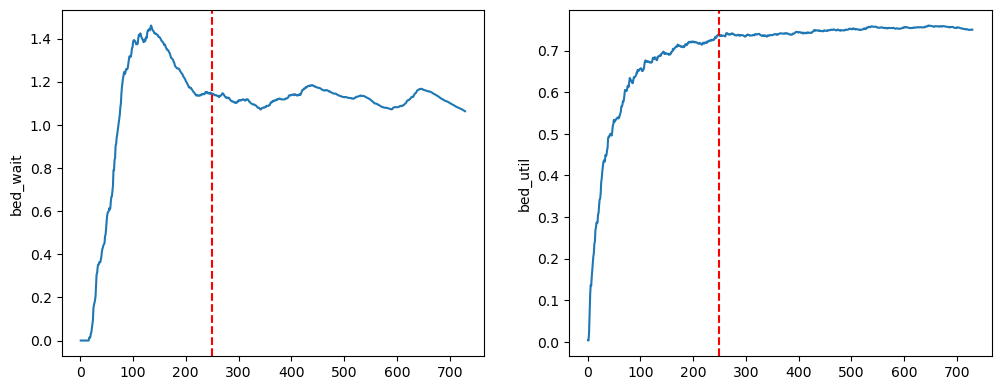

In [17]:
# this assumes you assigned the output of warmup_analysis to a varible 'results'
fig, ax = time_series_inspection(results, warm_up=250) #9 beds

# Estimating the number of replications

In [18]:
%%time 

WARM_UP = 250

RUN_LENGTH = 365

# number of replications
N_REPS = 100

# default scenario
args = Scenario()

# run multiple replications.
print('Running multiple replications', end=' => ')
replications  = multiple_replications(args, rc_period=RUN_LENGTH, warm_up=WARM_UP,
                                      n_reps=N_REPS)

print('done.\n')

# show results summary rounded to 2dp
replications.describe().round(2)

Running multiple replications => done.

CPU times: user 245 ms, sys: 9.84 ms, total: 255 ms
Wall time: 488 ms


,bed_util,bed_wait
count,100.00,100.00
mean,0.75,1.14
std,0.04,0.67
min,0.63,0.17
25%,0.72,0.63
50%,0.75,1.07
75%,0.78,1.43
max,0.84,3.25


In [19]:
def confidence_interval_method(replications, alpha=0.05, desired_precision=0.05, 
                               min_rep=5, decimal_place=2):
    '''
    The confidence interval method for selecting the number of replications
    to run in a simulation.
    
    Finds the smallest number of replications where the width of the confidence
    interval is less than the desired_precision.  
    
    Returns both the number of replications and the full results dataframe.
    
    Parameters:
    ----------
    replications: arraylike
        Array (e.g. np.ndarray or list) of replications of a performance metric
        
    alpha: float, optional (default=0.05)
        procedure constructs a 100(1-alpha) confidence interval for the 
        cumulative mean.
        
    desired_precision: float, optional (default=0.05)
        Desired mean deviation from confidence interval.
        
    min_rep: int, optional (default=5)
        set to a integer > 0 and ignore all of the replications prior to it 
        when selecting the number of replications to run to achieve the desired
        precision.  Useful when the number of replications returned does not
        provide a stable precision below target.
        
    decimal_places: int, optional (default=2)
        sets the number of decimal places of the returned dataframe containing
        the results
    
    Returns:
    --------
        tuple: int, pd.DataFrame
    
    '''
    n = len(replications)
    cumulative_mean = [replications[0]]
    running_var = [0.0]
    for i in range(1, n):
        cumulative_mean.append(cumulative_mean[i-1] + \
                       (replications[i] - cumulative_mean[i-1] ) / (i+1))
        
        # running biased variance
        running_var.append(running_var[i-1] + (replications[i] 
                                               - cumulative_mean[i-1]) \
                            * (replications[i] - cumulative_mean[i]))
        
    # unbiased std dev = running_var / (n - 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        running_std = np.sqrt(running_var / np.arange(n))
    
    # half width of interval
    dof = len(replications) - 1
    t_value = t.ppf(1 - (alpha / 2),  dof)    
    with np.errstate(divide='ignore', invalid='ignore'):
        std_error = running_std / np.sqrt(np.arange(1, n+1))
        
    half_width = t_value * std_error
        
    # upper and lower confidence interval
    upper = cumulative_mean + half_width
    lower = cumulative_mean - half_width
    
    # Mean deviation
    with np.errstate(divide='ignore', invalid='ignore'):
        deviation = (half_width / cumulative_mean) * 100
    
    # commbine results into a single dataframe
    results = pd.DataFrame([replications, cumulative_mean, 
                            running_std, lower, upper, deviation]).T
    results.columns = ['Mean', 'Cumulative Mean', 'Standard Deviation', 
                       'Lower Interval', 'Upper Interval', '% deviation']
    results.index = np.arange(1, n+1)
    results.index.name = 'replications'
    
    # get the smallest no. of reps where deviation is less than precision target
    try:
        n_reps = results.iloc[min_rep:].loc[results['% deviation'] 
                             <= desired_precision*100].iloc[0].name
    except:
        # no replications with desired precision
        message = 'WARNING: the replications do not reach desired precision'
        warnings.warn(message)
        n_reps = -1 

    
    return n_reps, results.round(2)
        

In [20]:
# run the method on the operator_wait replications
n_reps, conf_ints = \
    confidence_interval_method(replications['bed_wait'].to_numpy(),
                               desired_precision=0.05)

# print out the min number of replications to achieve precision
print(f'\nminimum number of reps for 5% precision: {n_reps}\n')

# peek at table of results
conf_ints.head()


minimum number of reps for 5% precision: -1



/tmp/ipykernel_1047/1893281968.py:86: UserWarning: WARNING: the replications do not reach desired precision
  warnings.warn(message)


,Mean,Cumulative Mean,Standard Deviation,Lower Interval,Upper Interval,% deviation
replications,,,,,,
1,0.91,0.91,NaN,NaN,NaN,NaN
2,1.11,1.01,0.14,0.82,1.21,19.44
3,1.23,1.09,0.16,0.90,1.27,16.94
4,2.00,1.31,0.47,0.84,1.78,35.79
5,0.42,1.13,0.57,0.63,1.64,44.67


In [21]:
def plot_confidence_interval_method(n_reps, conf_ints, metric_name, 
                                    figsize=(12,4)):
    '''
    Plot the confidence intervals and cumulative mean
    
    Parameters:
    ----------
    n_reps: int
        minimum number of reps selected
        
    conf_ints: pandas.DataFrame
       results of the `confidence_interval_method` function
       
    metric_name: str
        Name of the performance measure
        
    figsize: tuple, optional (default=(12,4))
        The size of the plot
        
    Returns:
    -------
        matplotlib.pyplot.axis
    '''
    # plot cumulative mean + lower/upper intervals
    ax = conf_ints[['Cumulative Mean', 'Lower Interval', 
                         'Upper Interval']].plot(figsize=figsize)
    # add the 
    ax.axvline(x=n_reps, ls='--', color='red')
    
    ax.set_ylabel(f'cumulative mean: {metric_name}')
    
    return ax

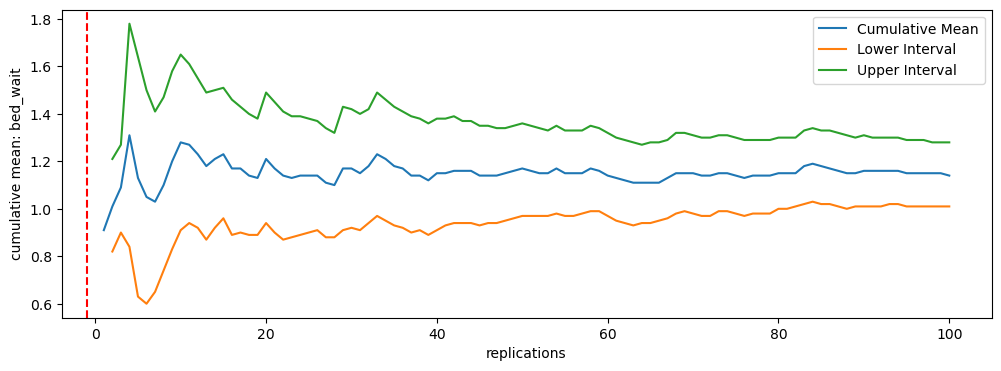

In [22]:
# plot the confidence intervals
ax = plot_confidence_interval_method(n_reps, conf_ints, 
                                     metric_name='bed_wait')

Analysis of replications for operator utilisation...

minimum number of reps for 5% precision: 51



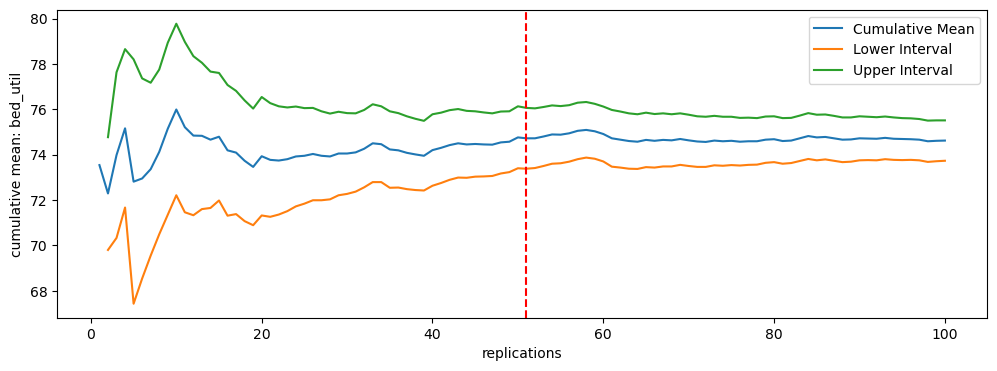

In [23]:
# run the method on the opts util replications
# We already know that we have to run > 50 reps so set min_rep parameter = 50.
n_reps, conf_ints = \
    confidence_interval_method(replications['bed_util'].to_numpy() * 100,
                               desired_precision=0.05, min_rep=50)

print('Analysis of replications for operator utilisation...')

#print out the min number of replications to achieve precision
print(f'\nminimum number of reps for 5% precision: {n_reps}\n')

#plot the confidence intervals
ax = plot_confidence_interval_method(n_reps, conf_ints, 
                                     metric_name='bed_util')

In [25]:
def get_scenarios():
    '''
    Creates a dictionary object containing
    objects of type `Scenario` to run.
    
    Returns:
    --------
    dict
        Contains the scenarios for the model
    '''
    scenarios = {}
    scenarios['base'] = Scenario()
    
    scenarios['beds_10'] = Scenario()
    scenarios['beds_10'].n_beds += 1
    
    scenarios['beds_11'] = Scenario()
    scenarios['beds_11'].n_beds += 2
    
    scenarios['beds_12'] = Scenario()
    scenarios['beds_12'].n_beds += 3
    
    scenarios['beds_13'] = Scenario()
    scenarios['beds_13'].n_beds += 4
    
    scenarios['beds_14'] = Scenario()
    scenarios['beds_14'].n_beds += 5    
    
    
    return scenarios

In [26]:
def run_scenario_analysis(scenarios, rc_period, warm_up, n_reps):
    '''
    Run each of the scenarios for a specified results
    collection period, warmup and replications.
    
    (note if you have lots of scenarios this may take several minutes)
    '''
    print('Scenario Analysis')
    print(f'No. Scenario: {len(scenarios)}')
    print(f'Replicatins: {n_reps}')
    
    
    scenario_results = {}
    for sc_name, scenario in scenarios.items():
        
        print(f'Running {sc_name}', end=' => ')
        replications  = multiple_replications(scenario, rc_period=RC_PERIOD, 
                                              warm_up=warm_up,
                                              n_reps=n_reps)
        print('done.\n')
        
        #save the results
        scenario_results[sc_name] = replications
    
    print('Scenario analysis complete.')
    return scenario_results

In [27]:
%%time
# script to run model

# set models warmup period
WARM_UP = 250

# results collection over a single day
RC_PERIOD = 365

# number of replications
N_REPS = 51

# get the scenarios
scenarios = get_scenarios()

# run the scenario analysis
scenario_results = run_scenario_analysis(scenarios, RC_PERIOD, WARM_UP,
                                         N_REPS)

Scenario Analysis
No. Scenario: 6
Replicatins: 51
Running base => done.

Running beds_10 => done.

Running beds_11 => done.

Running beds_12 => done.

Running beds_13 => done.

Running beds_14 => done.

Scenario analysis complete.
CPU times: user 829 ms, sys: 60.5 ms, total: 890 ms
Wall time: 1.77 s


In [28]:
def scenario_summary_frame(scenario_results):
    '''
    Mean results for each performance measure by scenario
    
    Parameters:
    ----------
    scenario_results: dict
        dictionary of replications.  
        Key identifies the performance measure
        
    Returns:
    -------
    pd.DataFrame
    '''
    columns = []
    summary = pd.DataFrame()
    for sc_name, replications in scenario_results.items():
        summary = pd.concat([summary, replications.mean()], axis=1)
        columns.append(sc_name)

    summary.columns = columns
    return summary

In [29]:
summary_frame = scenario_summary_frame(scenario_results)
summary_frame.round(2)

,base,beds_10,beds_11,beds_12,beds_13,beds_14
bed_util,0.76,0.68,0.62,0.57,0.51,0.48
bed_wait,1.36,0.40,0.19,0.07,0.02,0.01


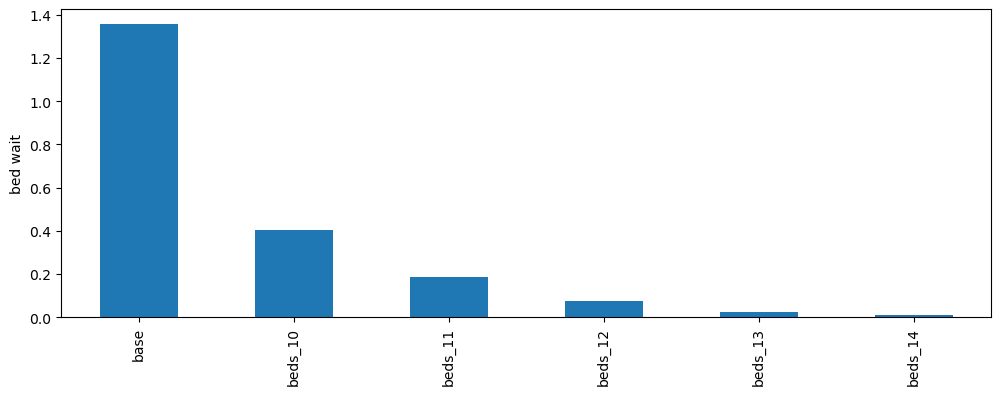

In [30]:
ax = summary_frame.T['bed_wait'].plot.bar(figsize=(12,4))
ax.set_ylabel('bed wait');

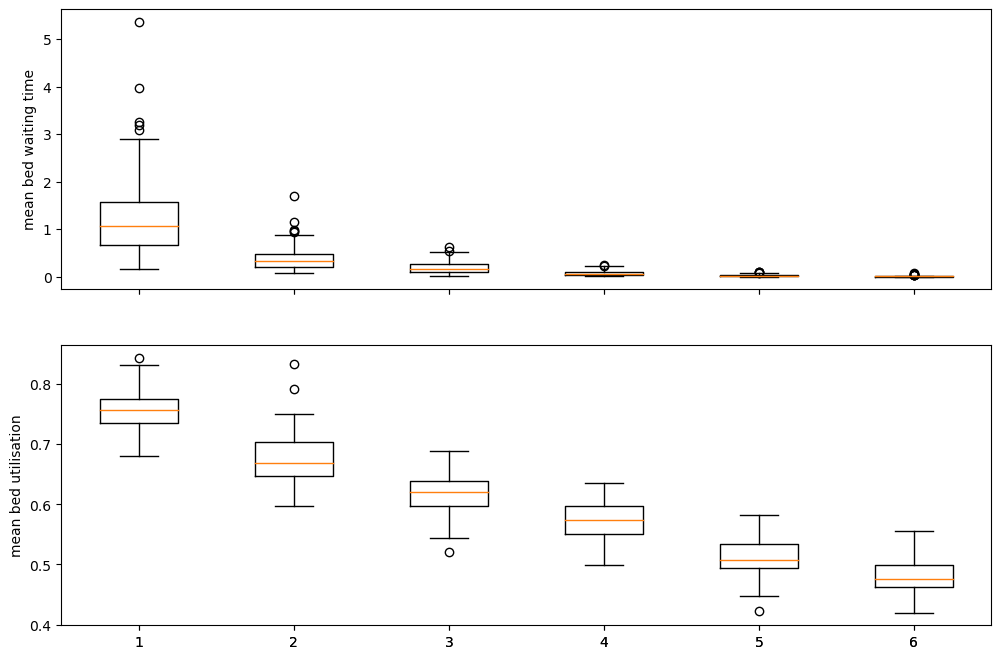

In [31]:
# preprocess the data first

def metric_by_scenario(select, scenario_results):
    metric = pd.DataFrame()
    columns = []
    for sc_name, replications in scenario_results.items():
        metric = pd.concat([metric, replications[select]], 
                           axis=1)
        columns.append(sc_name)

    metric.columns = columns
    return metric


metric_nw = metric_by_scenario('bed_wait', 
                               scenario_results)

metric_nu = metric_by_scenario('bed_util',
                               scenario_results)

fig, ax = plt.subplots(2, 1, figsize=(12,8), 
                       sharex=True)
ax[0].boxplot(metric_nw);
ax[1].boxplot(metric_nu);
ax[0].set_ylabel('mean bed waiting time')
ax[1].set_ylabel('mean bed utilisation');